### Comparing a pair of ACS Census Variables

In [5]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import cenpy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler
from geopandas import GeoDataFrame
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

scaler = StandardScaler()
%matplotlib inline


data = pd.read_csv('./data/data.csv')

In [6]:
df = pd.read_csv('./data/merged_acs.csv')

In [7]:
df.head()

,GEOID,geometry,< 10k,>200k,NAME,state,county,no schooling,8th grade,bachelors
0,1001,"POLYGON ((-9674008.4 3834487.29, -9674010.51 3...",743.0,86.0,"Autauga County, Alabama",1,1,267.0,331.0,6019.0
1,1003,"POLYGON ((-9795078.140000001 3575154.62, -9795...",2790.0,416.0,"Baldwin County, Alabama",1,3,1179.0,1174.0,31801.0
2,1005,"POLYGON ((-9510003.949999999 3769348.13, -9510...",798.0,10.0,"Barbour County, Alabama",1,5,391.0,520.0,1367.0
3,1007,"POLYGON ((-9719556.880000001 3906753.69, -9719...",368.0,7.0,"Bibb County, Alabama",1,7,418.0,247.0,1043.0
4,1009,"POLYGON ((-9656875.43 4028479.23, -9656857.07 ...",1170.0,39.0,"Blount County, Alabama",1,9,791.0,716.0,3432.0


In [8]:
df.drop('geometry', axis=1, inplace=True)

In [9]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [10]:
data = df.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')

In [11]:
data.drop(['name', 'id'], axis=1, inplace=True)
data.drop(data[(data.GEOID >= 15000) & (data.GEOID < 16000)].index, inplace=True)
data.drop(data[(data.GEOID >= 2000) & (data.GEOID < 4000)].index, inplace=True)

In [12]:
newgdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

<AxesSubplot:>

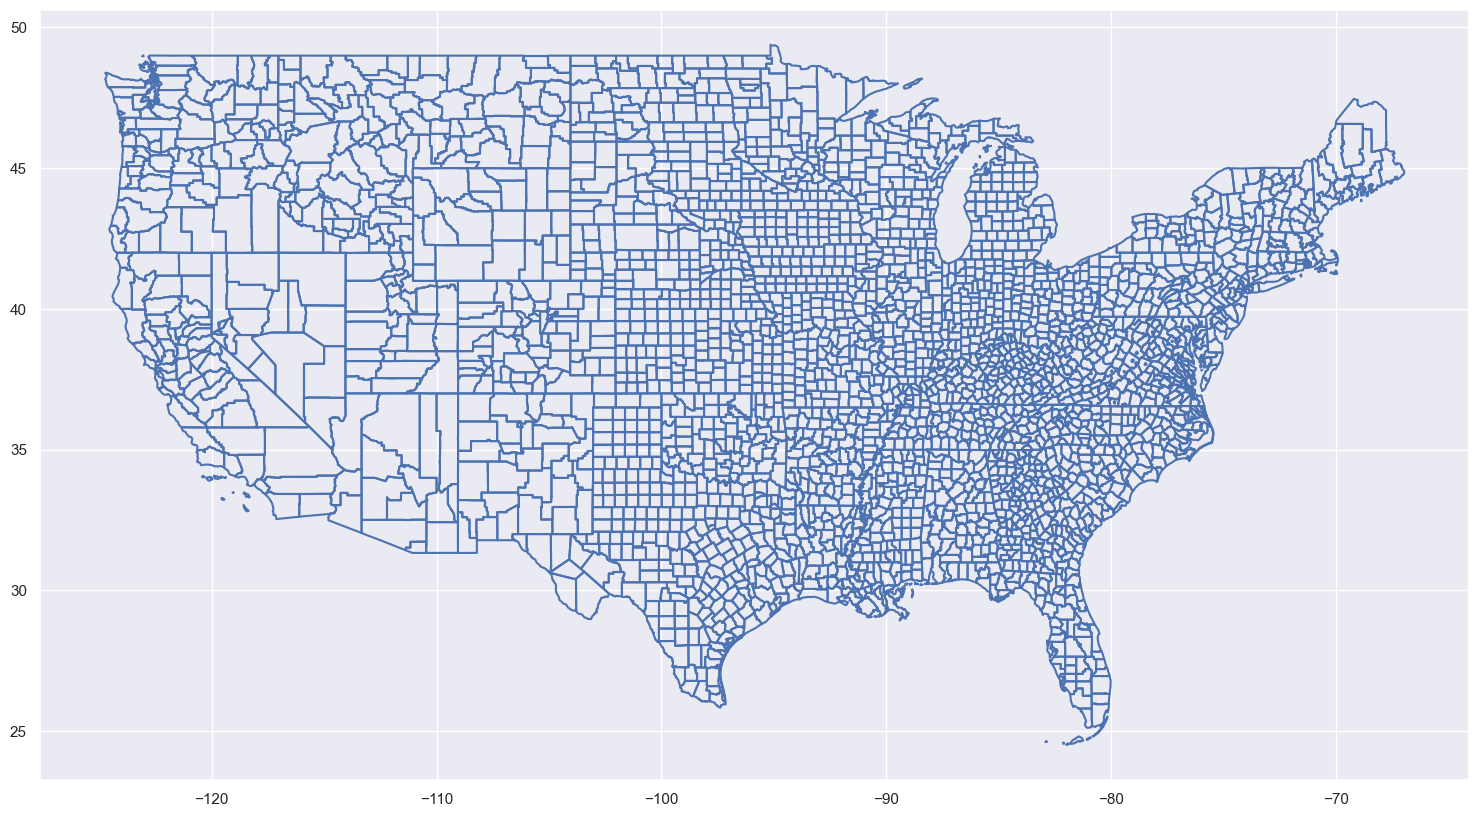

In [13]:
newgdf.boundary.plot()

In [14]:
newgdf.head()

,GEOID,< 10k,>200k,NAME,state,county,no schooling,8th grade,bachelors,geometry,lon,lat
0,1001,743.0,86.0,"Autauga County, Alabama",1,1,267.0,331.0,6019.0,"POLYGON ((-86.91684 32.66395, -86.71225 32.661...",-86.641721,32.535922
1,1003,2790.0,416.0,"Baldwin County, Alabama",1,3,1179.0,1174.0,31801.0,"POLYGON ((-88.00799 30.68468, -88.02593 30.753...",-87.723428,30.727208
2,1005,798.0,10.0,"Barbour County, Alabama",1,5,391.0,520.0,1367.0,"POLYGON ((-85.65700 31.88049, -85.64982 31.911...",-85.392290,31.869504
3,1007,368.0,7.0,"Bibb County, Alabama",1,7,418.0,247.0,1043.0,"POLYGON ((-87.42293 33.00328, -87.31884 33.005...",-87.128405,32.997662
4,1009,1170.0,39.0,"Blount County, Alabama",1,9,791.0,716.0,3432.0,"POLYGON ((-86.96350 33.85804, -86.92043 33.873...",-86.566051,33.981451


In [15]:
len(newgdf)

3106

### Modelling

In [18]:
g_y = newgdf["bachelors"].values.reshape((-1,1))
g_X = newgdf[[">200k"]].values

u = newgdf["lon"]
v = newgdf["lat"]

g_coords = list(zip(u,v))

In [24]:
%%time
gwr_selector_o = Sel_BW(g_coords, g_y, g_X, lwcc=False, constant=False)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()  # Use a fix bandwidth of 150
gwr_results_o.summary()

48.0
Model type                                                         Gaussian
Number of observations:                                                3106
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            930.977
Log-likelihood:                                                   -2536.080
AIC:                                                               5076.161
AICc:                                                              5078.168
BIC:                                                             -24028.570
R2:                                                                   0.700
Adj. R2:                                                              0.700

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

### GW Correlation Coefficient. Classic 

In [17]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, 150)
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]
    
newgdf['gwr_calc'] = corr_mat
corr_mat.mean()

0.9348664602809906

### Calculate GW CC using the new algorithm 

In [18]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, 150, constant=False, lwcc=True).fit()  # using a fixed bandwidth of 150
gwr_results_n.summary()

46.0
Model type                                                         Gaussian
Number of observations:                                                3106
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       2535271264133.574
Log-likelihood:                                                  -36275.141
AIC:                                                              72552.283
AICc:                                                             72554.287
BIC:                                                           2535271239165.987
R2:                                                                   0.681
Adj. R2:                                                              0.681

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- --

In [19]:
newgdf['new_algo_params'] = gwr_results_n.params

In [20]:
from utils import compare_surfaces

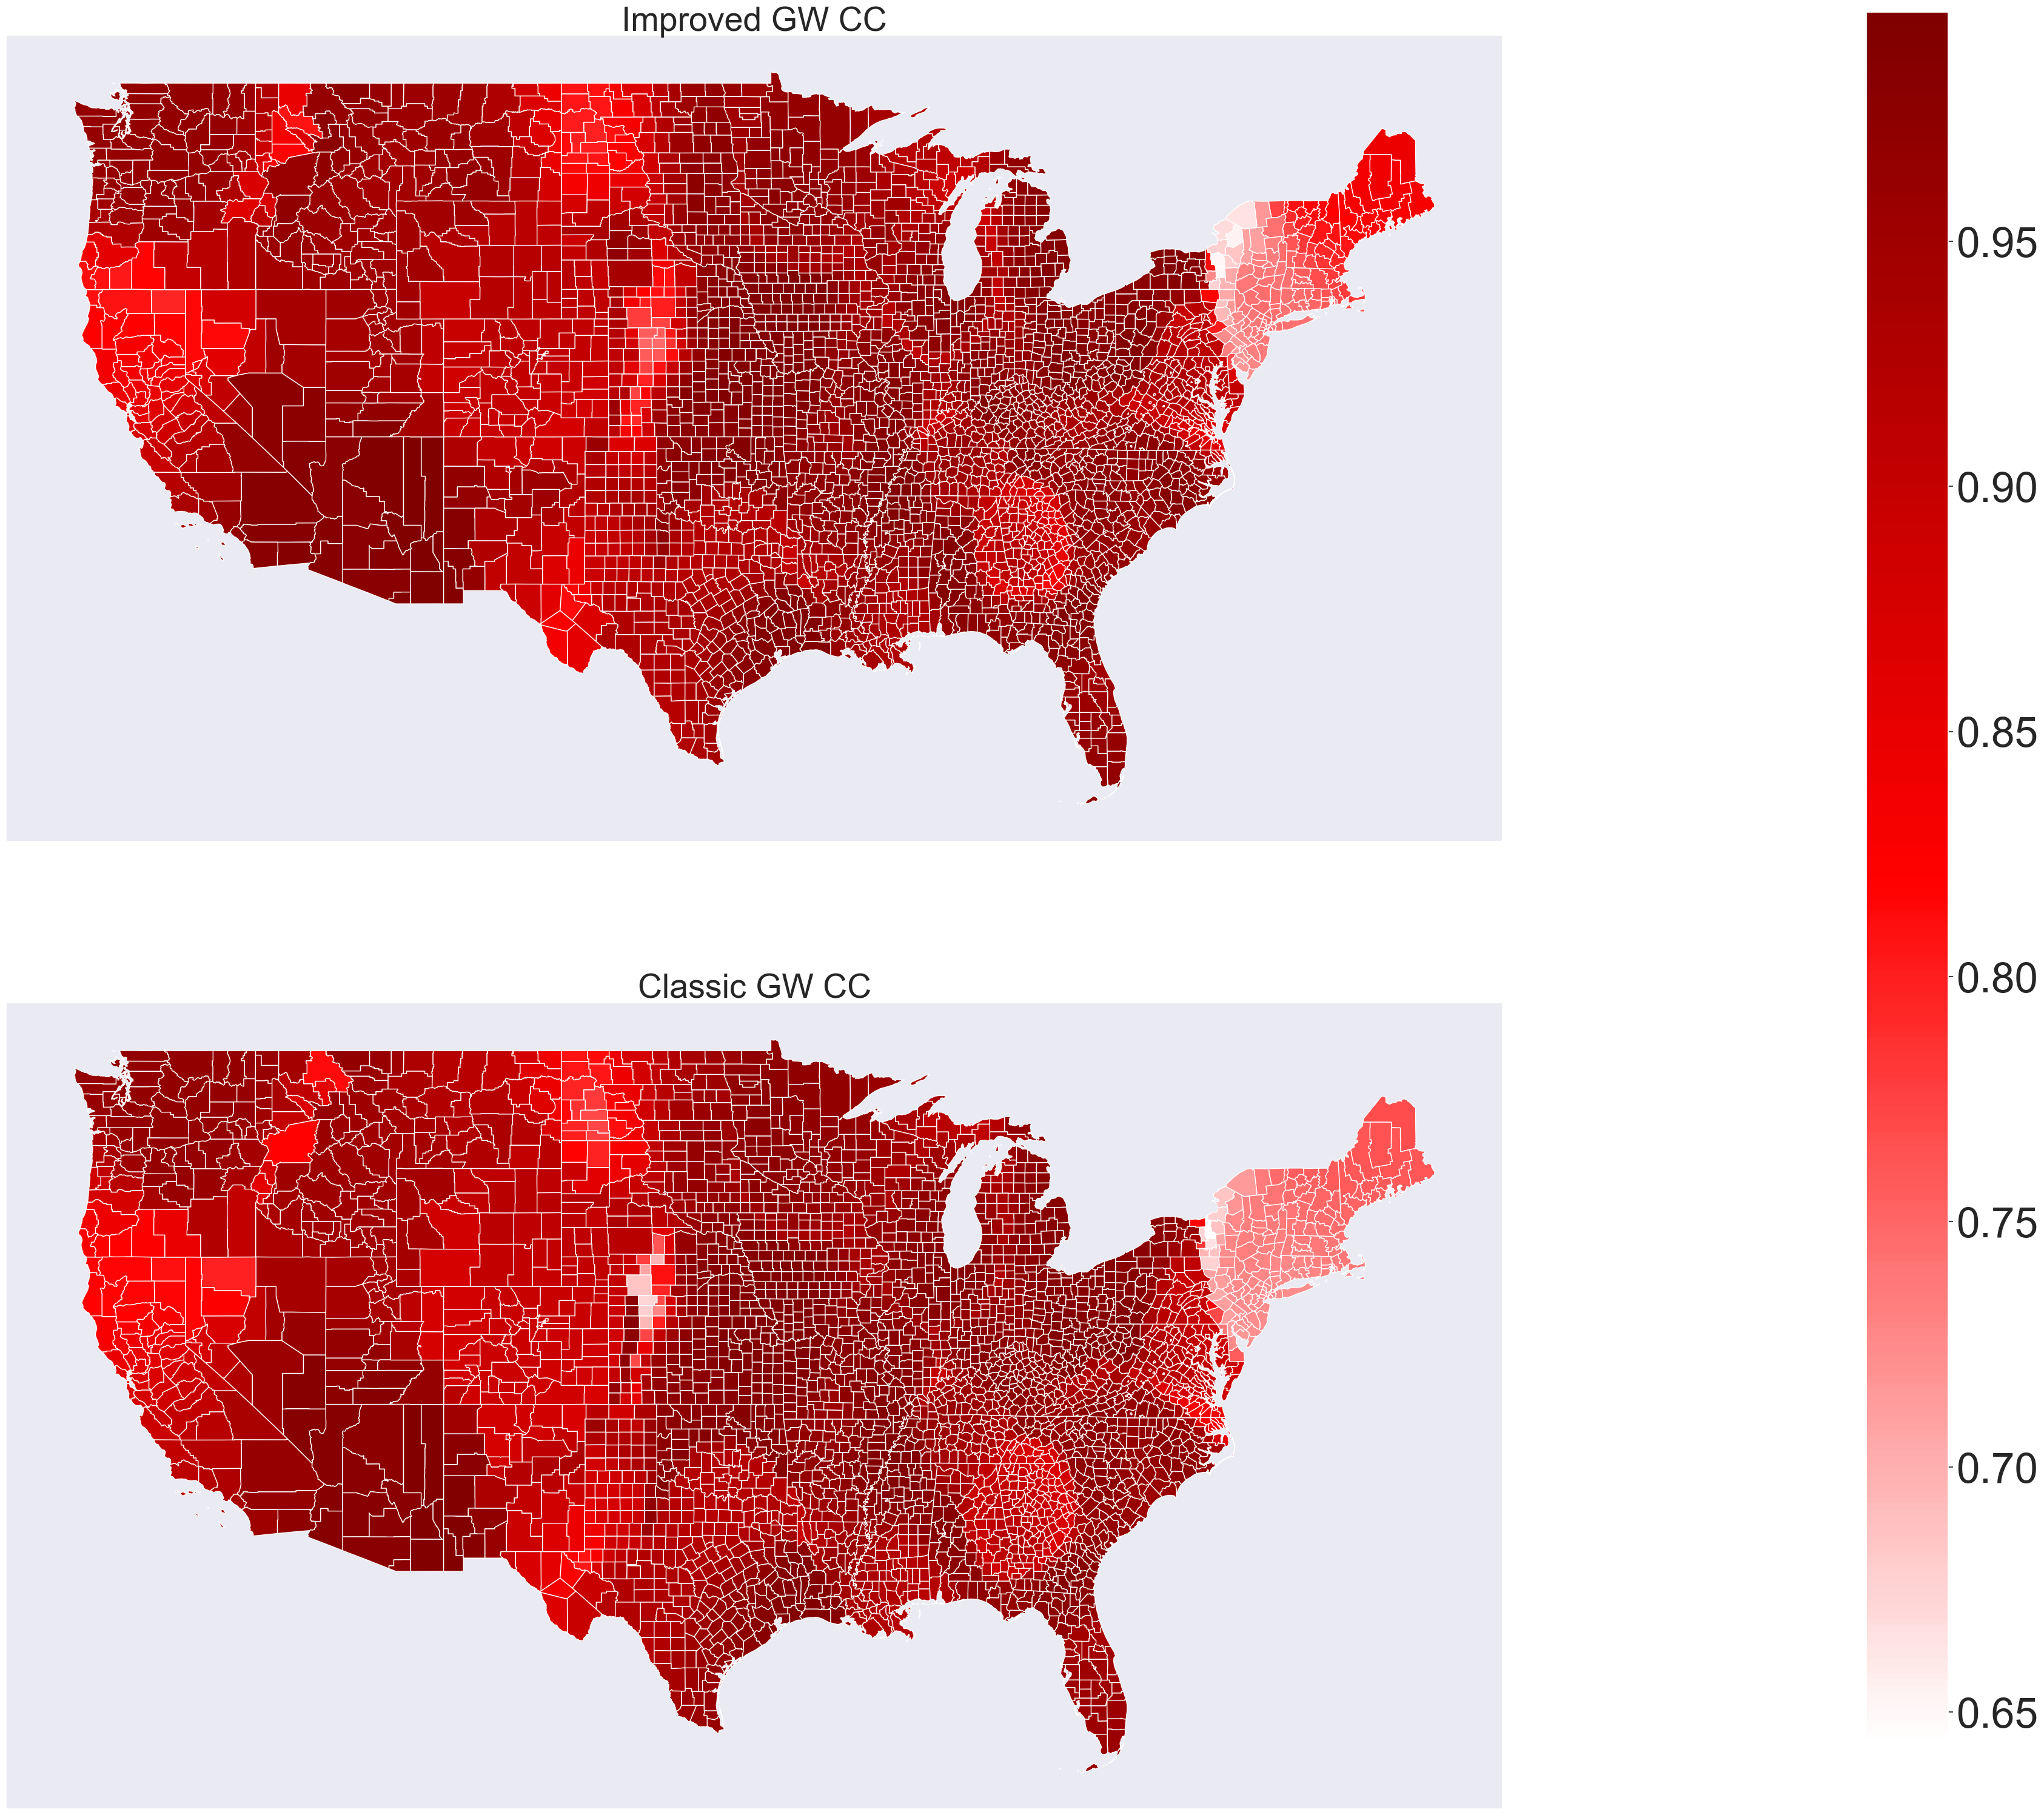

In [21]:
compare_surfaces(newgdf, 'new_algo_params', 'gwr_calc', savefig='./figs/fixed-bandwidth/use-case 1.png')

   ### Locally Weighted Pearson'sR 

In [23]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_n.model._build_wi(i, 150).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
    corr.append(corr_coef)

np.array(corr).mean()

0.938031299638834

In [17]:
# data = data.drop("Label", axis=1)

# data = data.apply(lambda x: x * 100) 

# gdf = gpd.read_file("./data/us-shapefile-states-data/COVID-19_global_time_series_panel_data-master/data/cb_2018_us_state_20m/cb_2018_us_state_20m.shp")
# gdf = gdf.to_crs("EPSG:4326")


# gdf = gdf[gdf.NAME!="Hawaii"]
# gdf = gdf[gdf.NAME!="Alaska"]
# gdf = gdf[['NAME', 'geometry']]
# # gdf.head()

# newdf = pd.concat([gdf, data], axis=1)
# # newdf = newdf.drop('id', axis=1)

# newdf['lon'] = newdf['geometry'].centroid.x
# newdf['lat'] = newdf['geometry'].centroid.y

# # newdf.head()
# # newdf.dtypes

# newdf = newdf.dropna()

# newgdf = GeoDataFrame(newdf, crs="EPSG:4326")  # change the EPSG, see whether the result changes
# ax = newgdf.boundary.plot()    
# newgdf.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);